In [1]:
import copy

import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from scipy.stats import norm

from utils import plot_sparsity_matrix,weight_histograms,set_all_seeds, plot_weight_histograms, make_paths_relative_to_root

import data as module_data
import models as module_arch
import evaluation as module_metric

import quantization as module_quantize
import pruning as module_prune

from parse_config import ConfigParser
from trainer.trainer import Trainer

make_paths_relative_to_root()

# Introduction
This notebook studies the Deep Compression process, described in the paper "Deep Compression: compressing deep neural networks with pruning, trained quantization and Huffman Coding, Song Han et al., 2016." [[1](#1)]
Here we replicate the results of the paper using MNIST dataset, using the LeNet-300-100 and LeNet-5 models [[2](#2)].

# Configuration
Images need to be rescaled from 28x28 to size 32x32 as described in LeCun et al. 1998

In [2]:
# Retrieve a pretrained model
config_dict = {'resume':'runs/models/Mnist_LeNet5/0305_221805/model_best.pth'}

config = ConfigParser.from_dict(config_dict)

data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

dataiter = iter(data_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([128, 1, 32, 32]) torch.Size([128])


Print images from dataset and their labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
9 0 9 0


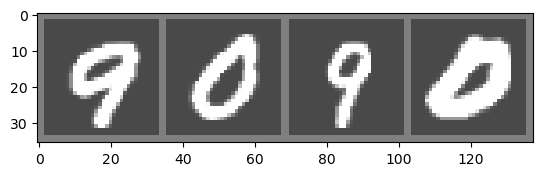

In [3]:
import matplotlib.pyplot as plt
from utils import imshow

# show images
imshow(torchvision.utils.make_grid(images[0:4]))
# print labels
print(' '.join(f'{labels[j]:1d}' for j in range(4)))

# LeNet-5

![Lenet5](./../assets/lenet-5_1.jpg "LeNet 5")

The input is a $32 \times 32$ image, since [[2](#2)] found desirable to have distinctive features of each character in the center of the receptive field of the highest-level feature detectors.

- C1 is a convolutional layer with 6 feature maps and a kernel of $5 \times 5$.
- S


In [4]:
 # build model architecture
model = config.init_obj('arch', module_arch)
print(model)

# get function handles of loss and metrics
criterion = getattr(F, config['loss'])
metrics = [getattr(module_metric, met) for met in config['metrics']]

# load pretrained model
print('Loading checkpoint: {} ...'.format(config.resume))
checkpoint = torch.load(config.resume)
state_dict = checkpoint['state_dict']
print('Accuracy before compression: {:.3f}'.format(checkpoint['monitor_best']))
model.load_state_dict(state_dict)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)
Loading checkpoint: runs\models\Mnist_LeNet5\0305_221805\model_best.pth ...
Accuracy before compression: 0.986


LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)

The error rate on the validation set is 2%, which is slightly worse than what declared in the paper and in the original article of LeCun et al. , 1998.

## Pruning

We have explored two ways of pruning:
- pruning a certain percentage of weights
- pruning all the weights under a threshold, given by the standard deviation of weight magnitude, multiplied by a quality constant $s$

$$ \text{threshold} = \sigma * s $$

In [5]:
pruners = config['pruners']
for pruner in pruners:
    # get type of pruning to use
    prune_fn = getattr(module_prune, pruner['type'])
    iterations = 1 if not 'iterations' in pruner else pruner['iterations']
    for it in range(iterations):
        # prune model
        model = module_prune.prune_model(model, prune_fn, pruner['levels'], None)

        # build optimizer, learning rate scheduler
        trainable_params = filter(lambda p: p.requires_grad, model.parameters())
        optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
        lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

        # avoid model reinitialization inside trainer
        config.resume = None

        trainer = Trainer(model, criterion, metrics, optimizer,
                          config=config,
                          device=device,
                          data_loader=data_loader,
                          valid_data_loader=valid_data_loader,
                          lr_scheduler=lr_scheduler)

        _, acc1, acc5 = trainer._valid_epoch(-1).values()
        #print("Pruning iteration - acc@1:{:.3f} | acc@5:{:.3f}".format(acc1, acc5))

        if pruner['finetune_weights']:
            trainer.train()

        _, acc1, acc5 = trainer._valid_epoch(-1).values()

        print("Pruning iteration {:d} | acc@1:{:.3f} | acc@5:{:.3f}".format(it, acc1, acc5))

Train Epoch: 1 [0/54000 (0%)] Loss: 1.434395
Train Epoch: 1 [1408/54000 (3%)] Loss: 1.051553
Train Epoch: 1 [2816/54000 (5%)] Loss: 0.784680
Train Epoch: 1 [4224/54000 (8%)] Loss: 0.625757
Train Epoch: 1 [5632/54000 (10%)] Loss: 0.558137
Train Epoch: 1 [7040/54000 (13%)] Loss: 0.483691
Train Epoch: 1 [8448/54000 (16%)] Loss: 0.360847
Train Epoch: 1 [9856/54000 (18%)] Loss: 0.311727
Train Epoch: 1 [11264/54000 (21%)] Loss: 0.297829
Train Epoch: 1 [12672/54000 (23%)] Loss: 0.256733
Train Epoch: 1 [14080/54000 (26%)] Loss: 0.237778
Train Epoch: 1 [15488/54000 (29%)] Loss: 0.294879
Train Epoch: 1 [16896/54000 (31%)] Loss: 0.270407
Train Epoch: 1 [18304/54000 (34%)] Loss: 0.172422
Train Epoch: 1 [19712/54000 (37%)] Loss: 0.176989
Train Epoch: 1 [21120/54000 (39%)] Loss: 0.209433
Train Epoch: 1 [22528/54000 (42%)] Loss: 0.173581
Train Epoch: 1 [23936/54000 (44%)] Loss: 0.148934
Train Epoch: 1 [25344/54000 (47%)] Loss: 0.185448
Train Epoch: 1 [26752/54000 (50%)] Loss: 0.130518
Train Epoch: 1 

We can see that validation accuracy drops after pruning, but once the model is finetuned, we reach a slightly better accuracy than the unpruned model. This was also noted in the Deep Compression paper

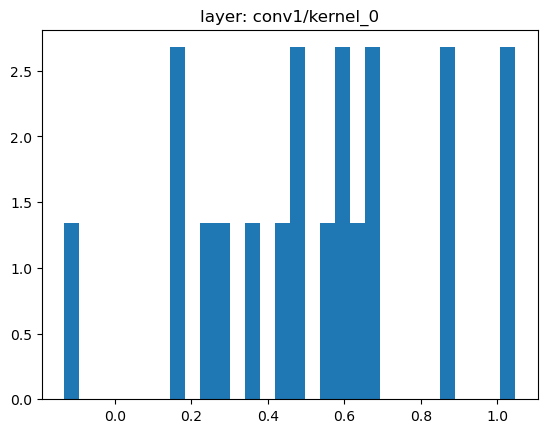

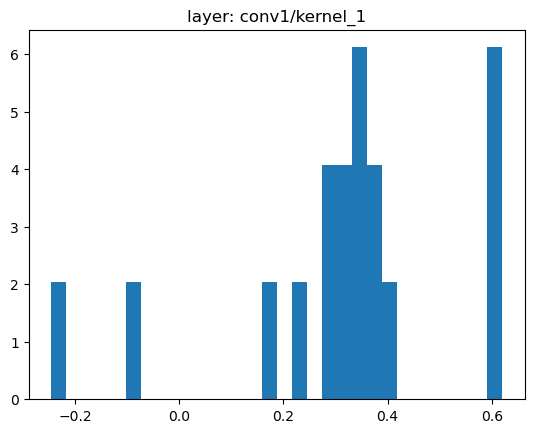

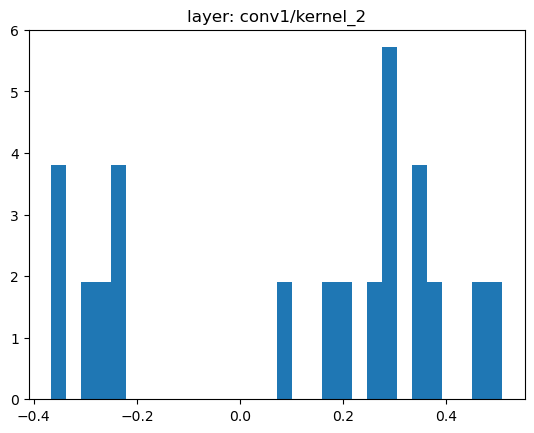

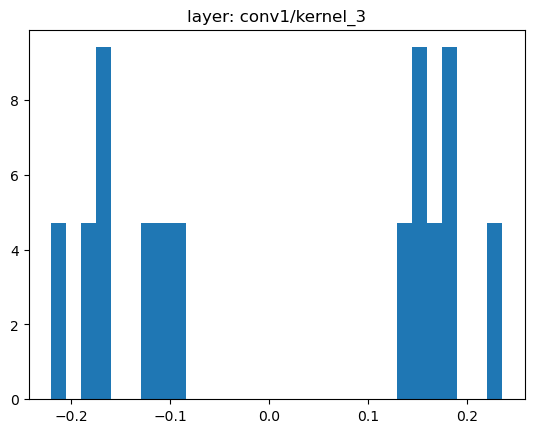

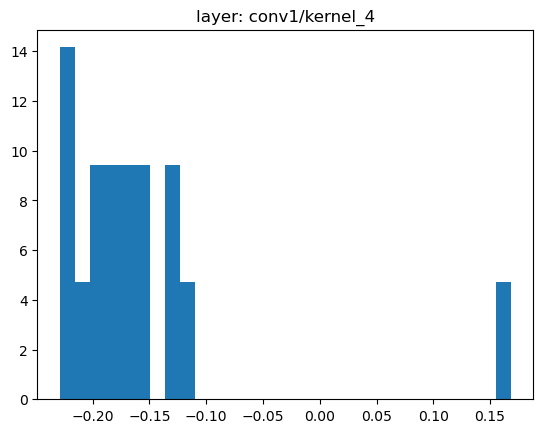

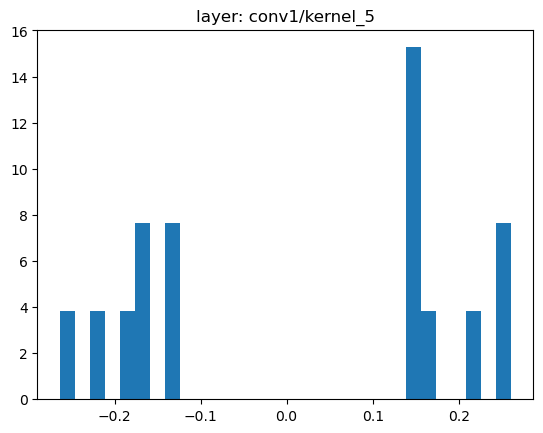

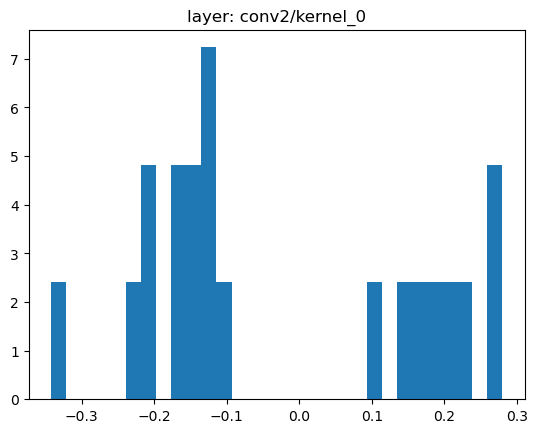

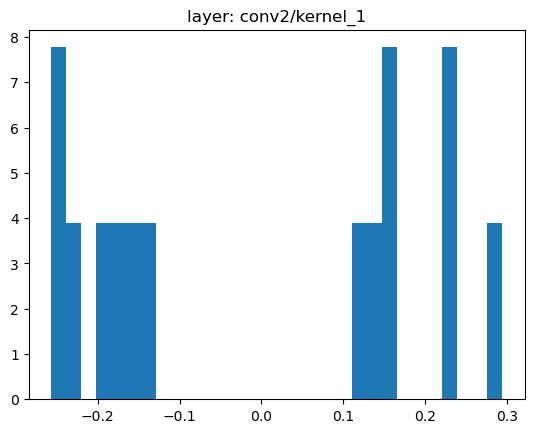

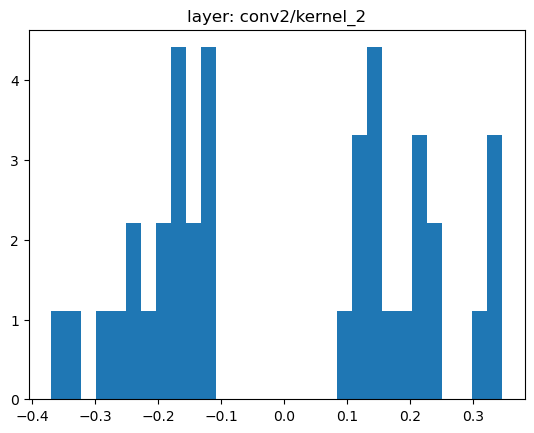

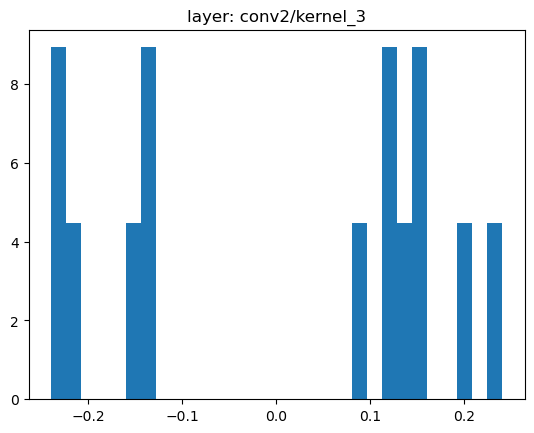

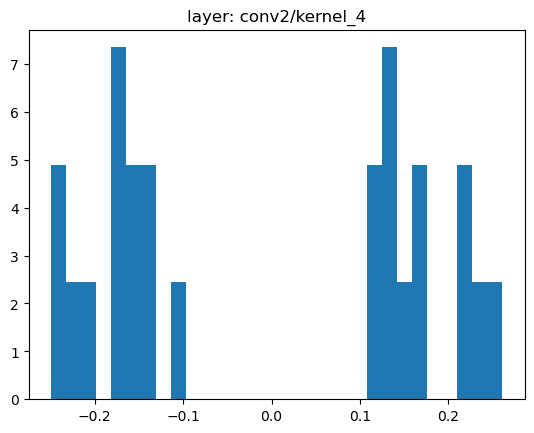

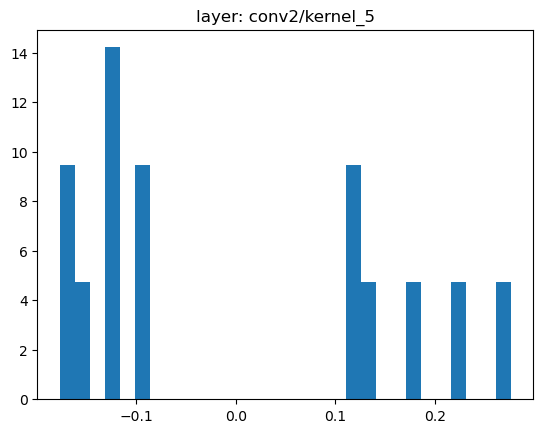

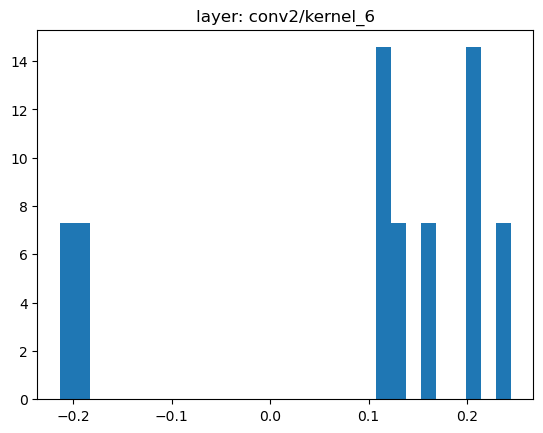

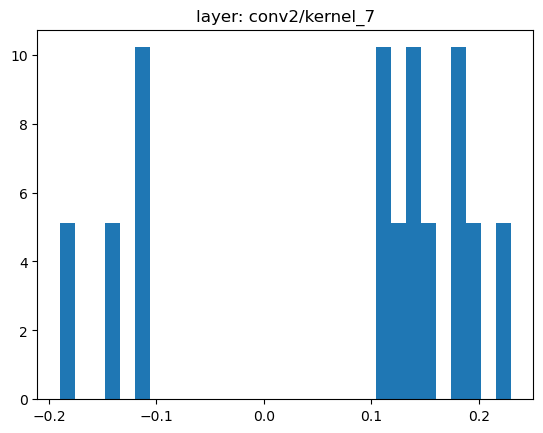

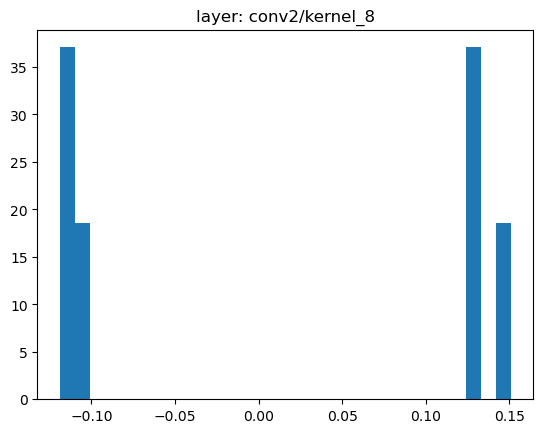

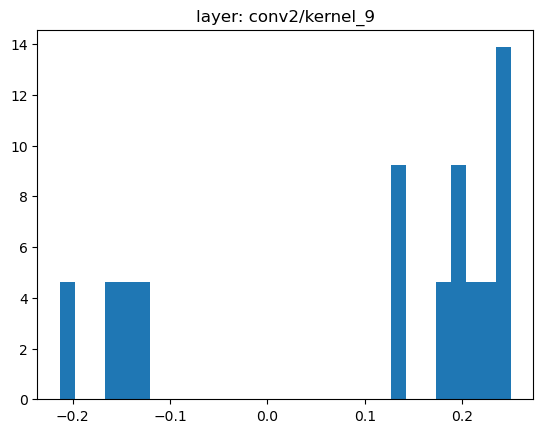

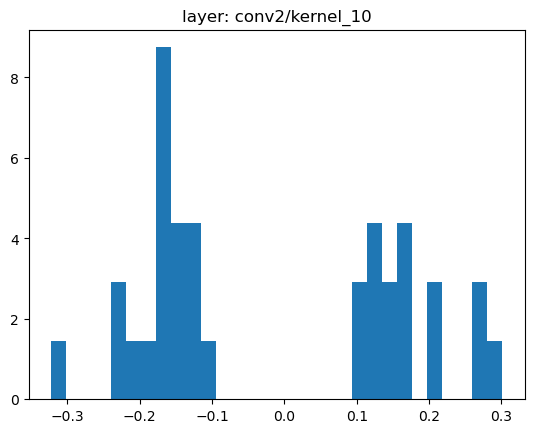

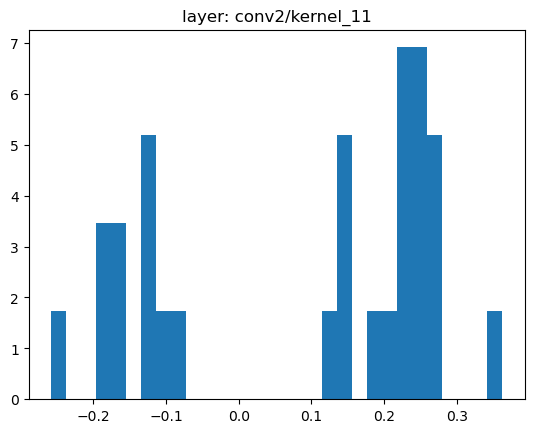

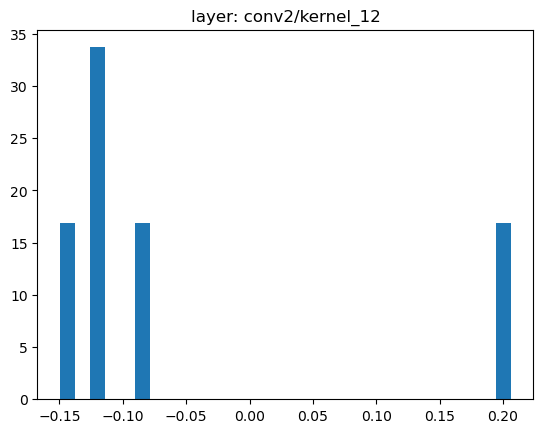

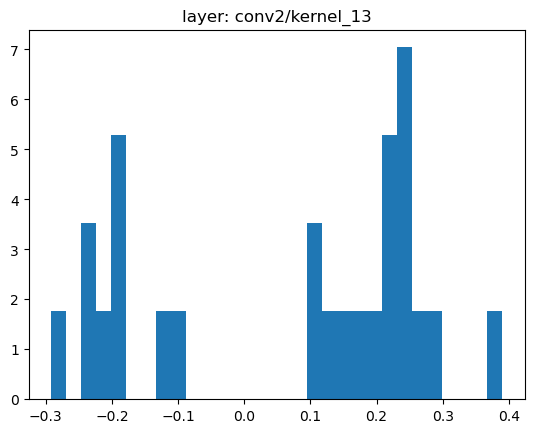

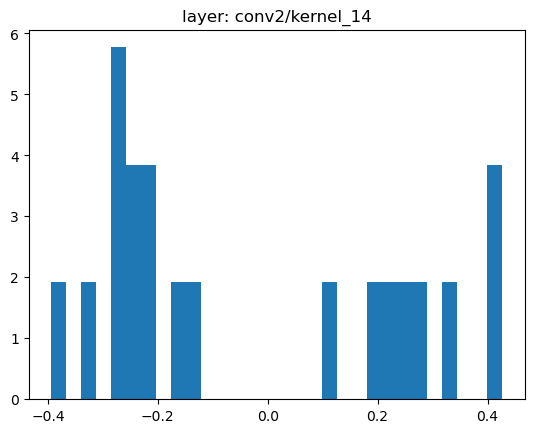

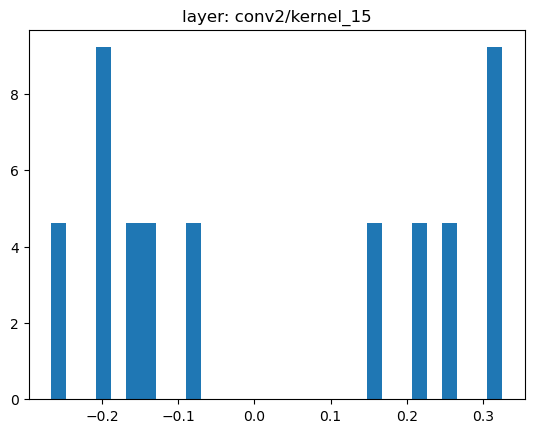

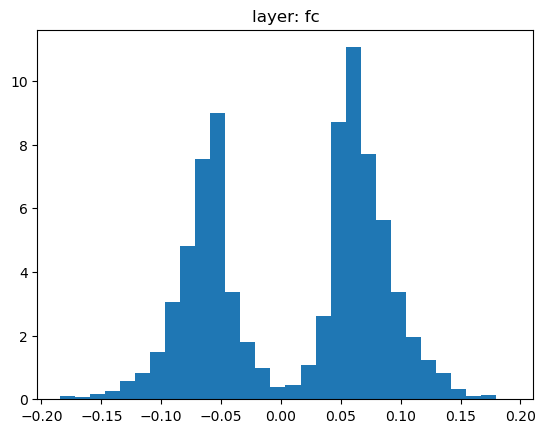

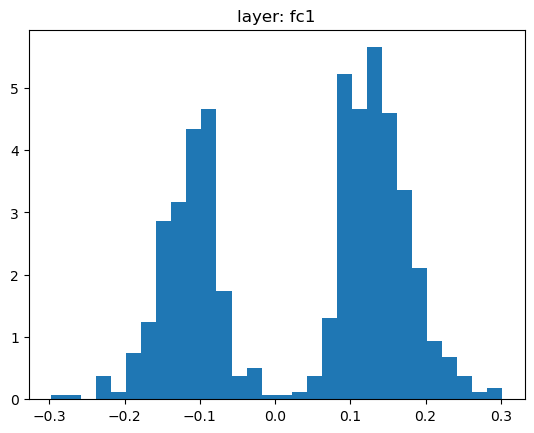

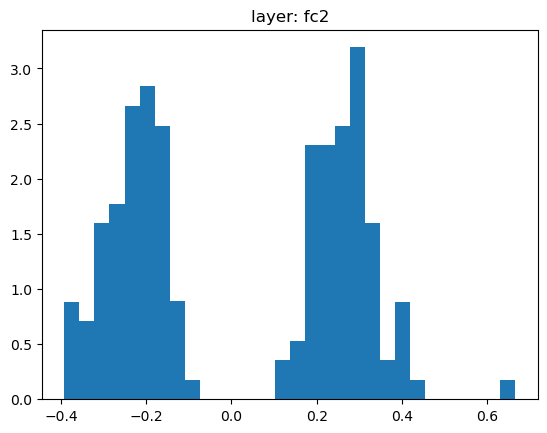

In [6]:
plot_weight_histograms(model)

Pruned weights follow a bimodal distribution

## Quantization

There are two ways of doing quantization:

- Reducing the number of bits used to represent each weight
- Create a codebook of weight values using a clustering algorithm, so that each weight that falls into the cluster will have the same shared weight.

We have implemented the latter using three different quantization methods, which can be found inside `quantization.py`.
All the methods extend a common class `BaseQuantizationMethod` and differ by the way the centroids are computed.

Let's show how the centroids are calculated for the weights of `fc1` layer, for simplicity let's assume to quantize the layer weights in only 3 bits (using 8 weights)

In [7]:
# Number of centroids = 2 ** #bits used to index
pts = 2 ** 3
mat = model.fc1.weight.detach().cpu().view(-1)
# ignore zeros from masked neurons
mat = mat[mat!=0]

### Random (Forgy) Initialization

Randomly chooses `pts` observations from the data set and uses these as the initial centroids. Since the pruned weights form a bimodal distribution, the centroids tend to concentrate around the two peaks.

In [8]:
space_f = np.random.choice(mat, size=pts, replace=False)

### Density-based Initialization

Linearly spaces the CDF in the y-axis, then finds the horizontal intersection with the CDF, and the vertical intersection on the x-axis, which becomes a centroid. Weights are concentrated around the two peaks, but more scattered than the Forgy method.

In [9]:
x, cdf_counts = np.unique(mat, return_counts=True)
y = np.cumsum(cdf_counts) / np.sum(cdf_counts)

eps = 1e-2

space_y = np.linspace(y.min() + eps, y.max() - eps, pts)

idxs = []
# TODO find numpy operator to eliminate for
for i in space_y:
    idx = np.argwhere(np.diff(np.sign(y - i)))[0]
    idxs.append(idx)

idxs = np.stack(idxs)
space_d = x[idxs]

### Linear Initialization
Linearly spaces the centroids between the [min, max] of the original weights. This initialization method is invariant to the distribution of the weights and more scattered compared with the other two methods.

In [10]:
min_ = mat.min()
max_ = mat.max()
space_l = np.linspace(min_, max_, num=pts)

We can visualize the centroids computed by these three methods and see how they are distributed with respect to the model PDF and CDF

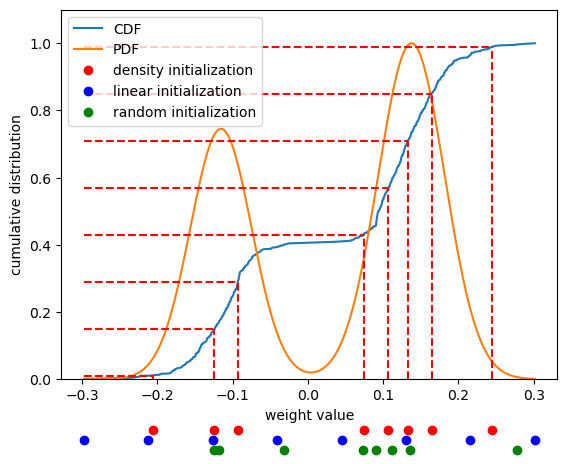

In [11]:
# credits https://stackoverflow.com/questions/55187037/how-can-i-do-a-histogram-with-1d-gaussian-mixture-with-sklearn
def normalize(x):
        return (x - x.min(0)) / x.ptp(0)

gmm = GMM(n_components=2, max_iter= 1000, random_state=0, covariance_type='full')
mean = gmm.fit(x.reshape(-1,1)).means_
covs  = gmm.fit(x.reshape(-1,1)).covariances_
weights = gmm.fit(x.reshape(-1,1)).weights_

x_ = np.arange(min_, max_, 1e-3)
y_gmm0 = norm.pdf(x_, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
y_gmm1 = norm.pdf(x_, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

fig, ax = plt.subplots()
ax.plot(x, y, label= 'CDF')
ax.plot(x_,normalize(y_gmm0+y_gmm1), label='PDF')

ax.set_ylabel('cumulative distribution')
ax.set_xlabel('weight value')
ax.set_ylim(0,1.1)

ax.plot(space_d,np.zeros_like(space_d) -0.15,'ro',clip_on=False,label='density initialization')
ax.plot(space_l,np.zeros_like(space_d) -0.18 ,'bo',clip_on=False,label='linear initialization')
ax.plot(space_f,np.zeros_like(space_d) -0.21,'go',clip_on=False,label='random initialization')

for idx in idxs:
    ax.hlines(y[idx], x.min(), x[idx], linestyles='--',colors='r')
    ax.vlines(x[idx], y.min(), y[idx], linestyles='--',colors='r')

ax.grid(False)
_ = ax.legend()

Finally, let's compare performances of the three methods:

| Network           | Quantization method | FC bits | Conv bits | Top-1 error |
|-------------------|---------------------|---------|-----------|-------------|
| LeNet-300-100 Ref | -                   | -       | -         | 2.0%        |
| LeNet-300-100 P+Q | forgy               | 6       | -         | 1.6%        |
| LeNet-300-100 P+Q | density             | 6       | -         | 1.5%        |
| LeNet-300-100 P+Q | linear              | 6       | -         | 1.5%        |
| LeNet-5 P+Q       | forgy               | 6       | 8         |             |
| LeNet-5 P+Q       | density             | 6       | 8         |             |
| LeNet-5 P+Q       | linear              | 6       | 8         |             |

Let's retrain a simple example with just 4 centers and visualize the result

In [13]:
quantizer = config['quantizer']
quantize_fn = module_quantize.linear_quantization

model_cpy = copy.deepcopy(model)

model_cpy = module_quantize.quantize_model(model_cpy, quantize_fn, quantizer['levels'], None)

# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model_cpy.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

trainer = Trainer(model_cpy, criterion, metrics, optimizer,
                  config=config,
                  device=device,
                  data_loader=data_loader,
                  valid_data_loader=valid_data_loader,
                  lr_scheduler=lr_scheduler)

_, acc1, acc5 = trainer._valid_epoch(-1).values()
print("Tested model after quantization - acc@1:{:.3f} | acc@5:{:.3f}".format(acc1, acc5))

if quantizer['finetune_weights']:
    trainer.train()

_, acc1, acc5 = trainer._valid_epoch(-1).values()
print("Tested model after finetuning - acc@1:{:.3f} | acc@5:{:.3f}".format(acc1, acc5))

Train Epoch: 2 [7040/54000 (13%)] Loss: 0.077974
Train Epoch: 2 [8448/54000 (16%)] Loss: 0.034682
Train Epoch: 2 [9856/54000 (18%)] Loss: 0.046294
Train Epoch: 2 [11264/54000 (21%)] Loss: 0.118517
Train Epoch: 2 [12672/54000 (23%)] Loss: 0.128313
Train Epoch: 2 [14080/54000 (26%)] Loss: 0.026163
Train Epoch: 2 [15488/54000 (29%)] Loss: 0.038045
Train Epoch: 2 [16896/54000 (31%)] Loss: 0.049570
Train Epoch: 2 [18304/54000 (34%)] Loss: 0.052621
Train Epoch: 2 [19712/54000 (37%)] Loss: 0.102578
Train Epoch: 2 [21120/54000 (39%)] Loss: 0.096840
Train Epoch: 2 [22528/54000 (42%)] Loss: 0.009715
Train Epoch: 2 [23936/54000 (44%)] Loss: 0.060461
Train Epoch: 2 [25344/54000 (47%)] Loss: 0.033858
Train Epoch: 2 [26752/54000 (50%)] Loss: 0.008835
Train Epoch: 2 [28160/54000 (52%)] Loss: 0.030462
Train Epoch: 2 [29568/54000 (55%)] Loss: 0.055077
Train Epoch: 2 [30976/54000 (57%)] Loss: 0.075968
Train Epoch: 2 [32384/54000 (60%)] Loss: 0.060073
Train Epoch: 2 [33792/54000 (63%)] Loss: 0.031626
Tra

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

Tested model after quantization - acc@1:0.981 | acc@5:1.000
Train Epoch: 1 [0/54000 (0%)] Loss: 0.127520
Train Epoch: 1 [1408/54000 (3%)] Loss: 0.038494
Train Epoch: 1 [2816/54000 (5%)] Loss: 0.024815
Train Epoch: 1 [4224/54000 (8%)] Loss: 0.049018
Train Epoch: 1 [5632/54000 (10%)] Loss: 0.046942
Train Epoch: 1 [7040/54000 (13%)] Loss: 0.092456
Train Epoch: 1 [8448/54000 (16%)] Loss: 0.008816
Train Epoch: 1 [9856/54000 (18%)] Loss: 0.054871
Train Epoch: 1 [11264/54000 (21%)] Loss: 0.044454
Train Epoch: 1 [12672/54000 (23%)] Loss: 0.102332
Train Epoch: 1 [14080/54000 (26%)] Loss: 0.044196
Train Epoch: 1 [15488/54000 (29%)] Loss: 0.027387
Train Epoch: 1 [16896/54000 (31%)] Loss: 0.048688
Train Epoch: 1 [18304/54000 (34%)] Loss: 0.047440
Train Epoch: 1 [19712/54000 (37%)] Loss: 0.057445
Train Epoch: 1 [21120/54000 (39%)] Loss: 0.048216
Train Epoch: 1 [22528/54000 (42%)] Loss: 0.040797
Train Epoch: 1 [23936/54000 (44%)] Loss: 0.052919
Train Epoch: 1 [25344/54000 (47%)] Loss: 0.054249
Train

weights: [-0.37156433 -0.36450356 -0.33536473 -0.3057102  -0.28739503 -0.28479454
 -0.2600546  -0.2573818  -0.2068344  -0.20114122 -0.15971223 -0.15189111
 -0.08157134  0.12853889  0.16289207  0.17208064  0.17809978  0.19424015
  0.21266013  0.23448867  0.25377795  0.2730945   0.28186142  0.29768395
  0.3101307   0.32865998  0.3304605   0.33141062  0.33345866  0.3912908
  0.42324737  0.67626417] - counts: [ 6  2  1  3  8  4 10  3 10  8  8 14  2  2  2  1 13  9  6  6  6  6  4  4
  3  6  2  2  2  3  3  1]


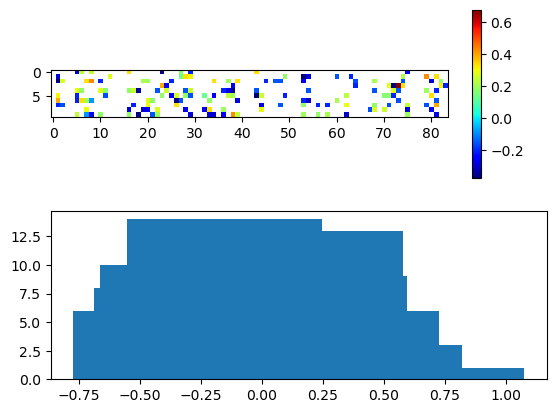

In [26]:
import matplotlib
from matplotlib.colors import ListedColormap

fig, (ax0,ax1) = plt.subplots(2,sharex=False,sharey=False)

weights = model_cpy.fc2.weight.detach().cpu()

# colors = ["#ff0000","#ffffff", "#00ff00", "#0000ff",'#000000']
# cmap = ListedColormap(colors,'mycolors',5)

a = np.ma.masked_where(weights ==0, weights)

cmap = matplotlib.cm.get_cmap("jet").copy()
cmap.set_bad(color='white')

plt1 = ax0.imshow(a,interpolation=None,cmap=cmap)
fig.colorbar(plt1,ax=ax0)

x, cdf_counts = np.unique(weights[weights!=0].view(-1), return_counts=True)
print("weights: {} - counts: {}".format( x, cdf_counts))

_ = ax1.bar(x,cdf_counts)

## Huffman encoding

# References
<a id="1">[1]</a> Han, Song, Huizi Mao, and William J. Dally. "Deep compression: Compressing deep neural networks with pruning, trained quantization and huffman coding." arXiv preprint arXiv:1510.00149 (2015).
<a id="1">[2]</a> LeCun, Yann, et al. "Gradient-based learning applied to document recognition." Proceedings of the IEEE 86.11 (1998): 2278-2324.
<a id="2">[3]</a> Han, Song, et al. "Learning both weights and connections for efficient neural network." Advances in neural information processing systems 28 (2015).